[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CCS-ZCU/pribehy-dat/blob/master/scripts/nlp.ipynb)

# NLP: Zpracování přirozeného jazyka

**autor**: *Vojtěch Kaše* (kase@ff.zcu.cz)

[![](https://ccs.zcu.cz/wp-content/uploads/2021/10/cropped-ccs-logo_black_space_240x240.png)](https://ccs.zcu.cz)

## Úvod a cíle kapitoly

Cílem tohoto cvičení je provést základní kvantitativní textovou analýzu některého digitalizovaného dokumentu z **Archivu Jana Patočky** ([AJP](https://archiv.janpatocka.cz/items/browse?tags=fulltext)). Omezíme se však pouze na dokumenty, u kterých je dostupný digitální přepis (tzv. fulltext). Tj. URL adresa, kterou hledáme, je adresa jakéhokoliv námi vybraného dokumentu z daného archivu pro který je dostupný přepis. Pro zvládnutí cvičení není potřeba nic více než na několika místech ručně nahradit jeden řetězec znaků za jiný pomocí Ctrl+C a Ctrl+V a ve správném pořadí spustit jednotlivé buňky pomocí ikony "play" či klávesové zkratky Shift+Enter.

Doklad o provedení cvičení bude nahrání Vámi upravené kopie jupyter notebooku ve formátu PDF do odevzdávárny v moodlu (viz níže).

Následující buňka je první klíčovou buňkou pro naše cvičení a  je potřeba ji spustit předtím, než buňky, které následují, neboť ty staví na funkcích, které v této buňce do aktuálního jupyter notebooku importujeme.

## Cvičení

In [1]:
# naše první buňka slouží k tomu, abychom do aktuálního GoogleColab skriptu
# importovali určité dodatečné balíčky (či knihovny) s funkcemi,
# které nejsou v "základní výbavě" Pythonu. Některé knihovny budeme muset dokonce nainstalovat

import requests
from urllib.request import urlopen # pro práci w webovými adresami
from urllib.parse import quote
from bs4 import BeautifulSoup # pro práci s webovými stránkami ve formátu html
import json
import re # pro práci s regulérními výrazy
import pandas as pd # pro práci s tabulkami ve formátu dataframe
import nltk # modul pro práci s textovými daty
from nltk import tokenize
nltk.download('punkt')
import matplotlib.pyplot as plt # modul pro vytváření grafů
import numpy as np # modul pro pokročilejší matematické operac

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Váš hlavní úkol je spojen s buňkou níže. V ní je potřeba nahradit obsah proměnné "url", tj. **vyměnit webovou adresu jednoho dokumentu z AJP za adresu jiného dokumentu z téhož archivu**.  Pozor, že webová adresa musí být uvnitř uvozovek. Aby se změna projevila, je třeba buňku nakonec spustit.

In [2]:
url = "https://archiv.janpatocka.cz/items/show/308"
web_text = urlopen(url).read().decode("utf-8")
soup = BeautifulSoup(web_text, "html.parser")

In [3]:
text_title = soup.find("div", id="item_title").get_text()
text_title

'Pražský filosofický kroužek'

In [4]:
[div for div in soup.find_all("div", class_="col span_7_of_9")][3].get_text()

'1935'

In [5]:
text_dokumentu = soup.find("div", id="trans_full").get_text()
text_dokumentu = " ".join(text_dokumentu.split())
print(text_dokumentu)

Pražský filosofický kroužek vznikl s účelem zintesivnění filosofické práce v Československu z některých popudů VIII. mezinárodního filosofického sjezdu v Praze na podnět univ. profesorů Kozáka a Utitze. Na rozdíl od způsobu práce velkých filosofických společností chce filosofický kroužek pěstovat úzkou součinnost co možná odbornou, takřka seminární, a proto neklade důraz na širokou účast veřejnosti. Pražský filosofický kroužek hodlá pořádati přednášky, diskuse, vydávati publikace a založiti filosofický archiv. Jednací řeči může býti kterýkoli jazyk. Společné práce jsou účastni Čechoslováci české i německé národnosti, kromě toho je přihlášena řada zahraničních spolupracovníků národnosti německé, francouzské, španělské, ruské aj. Program kroužku je pěstěni filosofie v duchu domácí tradice, representované jmény Komenský, Bolzano, Masaryk, to jest ve víře v universální teoretické i praktické posláni filosofie, která ovšem zde neni pochopena jako záležitost, interesujíci pouze intelekt, nýb

In [6]:
# dokument jako list slov získáme pomocí funkce "split()"
# uložíme si ho takto do nové proměnné "pdf_string_list"
string_list = text_dokumentu.split()
# tuto proměnnou si vypíšeme:
string_list[:20]

['Pražský',
 'filosofický',
 'kroužek',
 'vznikl',
 's',
 'účelem',
 'zintesivnění',
 'filosofické',
 'práce',
 'v',
 'Československu',
 'z',
 'některých',
 'popudů',
 'VIII.',
 'mezinárodního',
 'filosofického',
 'sjezdu',
 'v',
 'Praze']

In [7]:
### pomocí funkce "len()" spočítáme délku tohoto listu slov:
len(string_list)

1197

In [8]:
data = []
for n in range(0,3000):
  try:
    textdata = {}
    id = str(n)
    url = "https://archiv.janpatocka.cz/items/show/" + id
    web_text = urlopen(url).read().decode("utf-8")
    soup = BeautifulSoup(web_text, "html.parser")
    text_title = soup.find("div", id="item_title").get_text()
    date = [div for div in soup.find_all("div", class_="col span_7_of_9")][3].get_text()
    text_dokumentu = soup.find("div", id="trans_full").get_text()
    text_dokumentu = " ".join(text_dokumentu.split())
    print(id)
    textdata["id"] = id
    textdata["title"] = text_title
    textdata["date"] = date
    textdata["rawtext"] = text_dokumentu
    data.append(textdata)
  except:
    pass




2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676


In [9]:
data_df = pd.DataFrame(data)
data_df.head(5)

,id,title,date,rawtext
0,2651,Evropa a odpovědnost vědění,1974,[Evropa a odpovědnost vědění]1 (1974) Promysle...
1,2652,Evropa a její dědictví. Skica k filosofii dějin,1976,Evropa a její dědictví1 (Skica k filosofii děj...
2,2653,Komentář k eseji Války 20. století,1975,[Komentář k eseji Války 20. století] (1975) Vá...
3,2654,Poznámky posluchačů z přednášky Vznik a konec ...,1974,[Poznámky posluchačů z přednášky Vznik a konec...
4,2655,Mýtus,,"Mýtus Mýtus nelze definovat ani ""emocionálním ..."


In [10]:
data_df.to_csv("my_table.csv")

### Lematizace a postagging

S textem článku, tak jak se nyní nachází v proměnné "text_clanku", bychom se ale při kvantitativní textové analýze stále příliš daleko nedostali. Čeština je totiž morfologicky velice bohatý jazyk. Chceme-li např. spočítat kolikrát se v textu objevuje sloveso "mít", s textem v aktuální podobě se příliš daleko nedstaneme. Zde potřebujeme na naše textová data aplikovat dvě další procedury:


1.   lemmatizace, tj. převedení slov z textu do jejich základních tvarů (slovesa do infinitivu, podstatná jména do 1.pádu singuláru apod.)
2.   POS-tagging ("part-of-speech tags"),  tj. určení slovních druhů a mluvnických kategorií

Aplikace těchto procedur nám umožní získat data z hlediska kvantitativní textové analýzy výrazně zajímavější.

V případě češtiny se můžeme v tomto případě opřít o webové nástroje z dílny Ústavu formální a aplikované lingivistiky FF UK, konkrétně o nástroj [Morphodita](http://ufal.mff.cuni.cz/morphodita).

S našimi daty budeme postupovat tak, že z našeho jupyter notebooku vzneseme dotaz na webovou aplikaci MorphoDity,  a požádáme na dálku o lemmatizaci a postaging našich dat (tutoriál k webovému dotazování MorpohoDity se nachází [zde](http://lindat.mff.cuni.cz/services/morphodita/api-reference.php)).


In [11]:
sentences = tokenize.sent_tokenize(text_dokumentu)
sentences[:10]

['[Studie o času I]1 Chtěli bychom nyní ukázat podrobněji, jak se tato oslovenost Ideou projevuje u jedné ze základních struktur, jež dávají svůj ráz životu člověka v jeho odlišnosti vůči základnějším a přitom jednodušším stupňům jsoucna.',
 'Míníme strukturu času.',
 'Čas je náš universální horizont a jako horizont je půdou pro nejpestřejší rozmanitost apriorních poznatků subjektivních i objektivních.',
 'Zde však nechceme postupovat analyticky, rozborem naší zkušenosti o čase, časového vědomí a časové formy lidského života, nýbrž komparativně-onticky: nechceme zde zjišťovat, co a priori víme o čase, nýbrž klademe si otázku, co čas jest na různých úrovních předmětnosti, co znamená čas v universu v jeho různých poschodích.',
 '* Všecky předměty jsou seřazeny v určitém pořádku, který myšlenkově izolujeme a získáváme tím všeobecné pořádkové formy prostor a čas.',
 'Jsou obecné, protože se jim nevymyká žádný předmět, žádné předmětné určení, vztah či děj; jsou to formy, poněvadž je myslíme

In [12]:
morfologicky_zpracovana_data = []
# nejprve opět vzneseme webový dotaz s textem našeho článku
for sentence in sentences:
  url = 'http://lindat.mff.cuni.cz/services/morphodita/api/tag?data=' + quote(sentence)
  resp = urlopen(url)
  resp_content = resp.read().decode("utf-8")
  # výsledky dotazu (zpracovaná data) si uložíme do proměnné "result"
  result = dict(json.loads(resp_content))["result"]
  # result má stromovou strukturu, kterou opět rozšifrujeme pomocí BeautifulSoup
  soup = BeautifulSoup(result, 'html.parser')
  # pro každé jednotlivé slovo si do jedné řádky vedle sebe vytahneme jeho (a) tvar jak je v textu, (b) lemmatizovanou podobu a (c) morfologické určení
  # tato data budeme postupně přidávat do samostatné proměnné "morfologicky_zpracovana_data"
  for token in soup.find_all("token"):
    morfologicky_zpracovana_data.append([token.get_text(), token["lemma"].partition("-")[0].partition("_")[0], token["tag"]])
# z těchto dat si vytvoříme úhlednou tabulku ve formátu DataFrame (df):
data_df = pd.DataFrame(morfologicky_zpracovana_data)
# sloupce si pojmenujeme
data_df.columns = ["slovo_puvodni", "lemma", "POS-tag"]
# výsledný dataset si vypíšeme
data_df



díky prvním písmenům třetího sloupce nyní víme, o jaký slovní druh se jedná:
*   "V..." = sloveso
*   "N..." = podstatné jméno
*   "A..." = přídavné jméno

Pro naše potřeby může bát zajímavé filtrovat tabulku tak, aby nám z textu zůstaly pouze tyto slovní druhy.


In [13]:
data_df_filtrovana = data_df[data_df["POS-tag"].str.startswith(("V","N","A"))]
data_df_filtrovana

,slovo_puvodni,lemma,POS-tag
1,Studie,studie,NNFS1-----A----
3,času,čas,NNIS6-----A---1
7,Chtěli,chtít,VpMP---XR-AA---
8,bychom,být,Vc-P---1-------
10,ukázat,ukázat,Vf--------A----
...,...,...,...
359,není,být,VB-S---3P-NA---
360,možná,možný,AAFS1----1A----
361,obsahová,obsahový,AAFS1----1A----
362,diferenciace,diferenciace,NNFS1-----A----


V této podobě může být již vcelku zajímavé podívat se na frekvence výskytů slov, resp. jejich lematizovaných tvarů. K tomu použijeme funkce z modulu "nltk".

In [14]:
# nejprve si z naší filtrované tabulky vyxtrahujeme lemmata samotná
lemmata = data_df_filtrovana["lemma"].tolist()
# pro každý jednotlivý výraz necháme spočítat jeho počet výskytů
lemmata_freq = nltk.FreqDist(lemmata)
# vybereme např. 10 nejfrekventovanějších slov (rozumějme lemmatizovaných substantiv, adjektiv a sloves)
lemmata_most_freq = lemmata_freq.most_common(10)
print(lemmata_most_freq)

[('být', 13), ('čas', 9), ('forma', 7), ('chtít', 3), ('ráz', 3), ('různý', 3), ('schéma', 3), ('obsah', 3), ('samostatný', 3), ('projevovat', 2)]


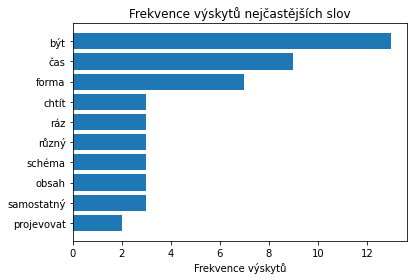

In [15]:
# kvůli horizontálnímu zobrazení prohodíme pořadí na našem listu
lemmata_mostfreq = lemmata_most_freq
lemmata_mostfreq.reverse()

# pro potřeby grafu přiřadíme hodnoty jednotlivým osám
height = [tup[1] for tup in lemmata_mostfreq]
bars = [tup[0] for tup in lemmata_mostfreq]
y_pos = np.arange(len(bars))

plt.barh(y_pos, height)
# graf si pojmenujeme a osu také
plt.yticks(y_pos, bars)
plt.xlabel('Frekvence výskytů')
plt.title('Frekvence výskytů nejčastějších slov')
# graf si zobrazíme
plt.show()

Pokud jsme se bez chybové hlášky dostali až sem a pomocí buňky výše jsme úspěšně vykreslili graf nejfrekventovanějších termínů v námi zvoleném dokumentu z AJP, hlavní část našeho úkolu byla splněna.

Abychom doložili svůj úspěch, náš výsledný jupyter notebook si vytiskneme do PDF (nabídka File -> Print) a nahrajeme na příslušné místo do Google Classroomu.